# **Dance of the Planets**

This notebook helps in developing a Neural Network to build a simulation of motion for two mass bodies and calculating and plotting their trajectories with time, as they follow Newtons Law of Gravitaion

**Importing Required Libraries**

In [11]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
G = 1 #For easy calculation and simple data plotting

**Taking Initial Input Values**

In [12]:
m1 = float(input("Enter mass of body 1 : ")) #Takes mass of the two bodies
m2 = float(input("Enter mass of body 2 : "))

x1_0 = np.array(list(map(float, input("Enter initial position of body 1 as x y: ").split()))) # Takes postion as components for body 1
x2_0 = np.array(list(map(float, input("Enter initial position of body 2 as x y: ").split()))) # Takes postion as components for body 2
v1_0 = np.array(list(map(float, input("Enter initial velocity of body 1 as vx vy: ").split()))) # Takes velocity as components for body 1
v2_0 = np.array(list(map(float, input("Enter initial velocity of body 2 as vx vy: ").split()))) # Takes velocity as components for body 2

T = float(input("Enter time of prediction : "))

Enter mass of body 1 : 1.0
Enter mass of body 2 : 1.0
Enter initial position of body 1 as x y: -1.0 0.0
Enter initial position of body 2 as x y: 1.0 0.0
Enter initial velocity of body 1 as vx vy: 0.0 -0.5
Enter initial velocity of body 2 as vx vy: 0.0 0.5
Enter time of prediction : 10


**Data Generation cell**

In [13]:
def two_body_ode(t, y): # function two generate ODE's based on Newtons laws
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = y
    r1 = np.array([x1, y1])
    r2 = np.array([x2, y2])
    r = r2 - r1
    dist = np.linalg.norm(r)
    a1 = G * m2 * r / dist**3
    a2 = -G * m1 * r / dist**3
    return [vx1, vy1, vx2, vy2, a1[0], a1[1], a2[0], a2[1]]

# Ensure v1_0 and v2_0 are 2D (vx, vy)
if v1_0.shape[0] == 1:
    v1_0 = np.array([v1_0[0], 0.0])
if v2_0.shape[0] == 1:
    v2_0 = np.array([v2_0[0], 0.0])

y0 = [*x1_0, *x2_0, *v1_0, *v2_0]
t_eval = np.linspace(0, T, 500) # Generating data on basis of time
sol = solve_ivp(two_body_ode, (0, T), y0, t_eval=t_eval)

split = int(0.8 * len(t_eval)) # Splitting the data for train:test in 80:20 form
train_X = t_eval[:split]
train_y = sol.y.T[:split]
test_X = t_eval[split:]
test_y = sol.y.T[split:]

**Model Definition of the required Neural Network**

In [14]:
class Two_Body_NN(nn.Module): #Defining a class to build a model for Neural Network
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 8)
        )

    def forward(self, t):
        return self.net(t)

model = Two_Body_NN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()  # Taking the loss_fn as object for calculating Mean Square Error function

**Training on the Data Set**

In [15]:
t_train = torch.tensor(train_X.reshape(-1, 1), dtype=torch.float32)
y_train = torch.tensor(train_y, dtype=torch.float32)

for epoch in range(1000): # Trainin epochs
    pred = model(t_train)
    loss = loss_fn(pred, y_train)
    optimizer.zero_grad() # Clears previous gradients from last epoch
    loss.backward()
    optimizer.step() # Computes the gradient of the loss with respect to all model weights
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.5f}")

Epoch 0: Loss = 0.39977
Epoch 100: Loss = 0.01771
Epoch 200: Loss = 0.00578
Epoch 300: Loss = 0.00276
Epoch 400: Loss = 0.00154
Epoch 500: Loss = 0.00096
Epoch 600: Loss = 0.00065
Epoch 700: Loss = 0.00047
Epoch 800: Loss = 0.00036
Epoch 900: Loss = 0.00028


**Testing and Model Evaluation Cell**

In [16]:
t_test = torch.tensor(test_X.reshape(-1, 1), dtype=torch.float32) # Testing set
y_test = test_y
pred_test = model(t_test).detach().numpy()

mae = mean_absolute_error(y_test[:, :4], pred_test[:, :4]) # calculating the Mean absolute error between the predicted and true values
print(f"MAE on test set (positions only): {mae:.4f}")

def compute_ode_residual(y_pred): #Method to compute ODE residuals
    residuals = []
    for i in range(len(y_pred)):
        x1, y1, x2, y2, vx1, vy1, vx2, vy2 = y_pred[i]
        r1 = np.array([x1, y1])
        r2 = np.array([x2, y2])
        r = r2 - r1
        dist = np.linalg.norm(r)
        a1 = G * m2 * r / dist**3
        a2 = -G * m1 * r / dist**3
        residuals.append(np.linalg.norm(a1 + a2))
    return np.mean(residuals)

ode_residual = compute_ode_residual(pred_test)
print(f"Mean ODE residual: {ode_residual:.5f}")

MAE on test set (positions only): 0.3373
Mean ODE residual: 0.00000


**Output Cell**

In [17]:
t_single = torch.tensor([[T]], dtype=torch.float32)
final_pos = model(t_single).detach().numpy().flatten()
print(f"Predicted position at T={T}:")
print(f"x1 = {final_pos[0:2]}")
print(f"x2 = {final_pos[2:4]}")

Predicted position at T=10.0:
x1 = [0.36394587 1.4952528 ]
x2 = [-0.3533819 -1.523025 ]


**Plotting the trajectory**

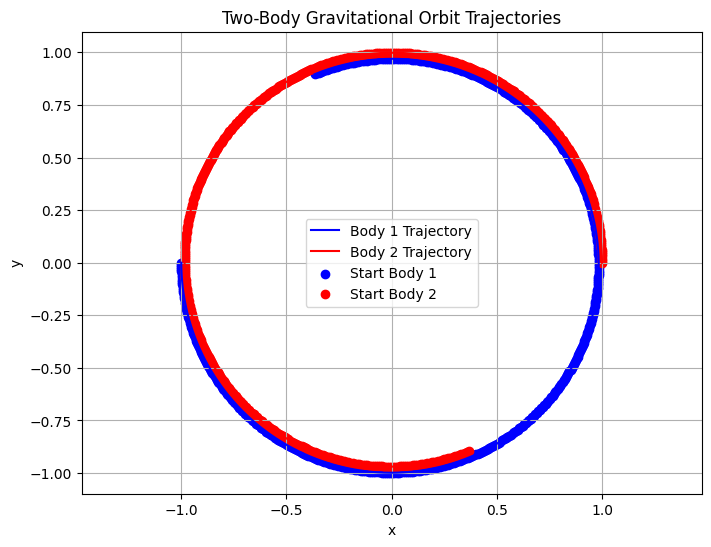

In [18]:
x1_traj = sol.y[0]
y1_traj = sol.y[1]
x2_traj = sol.y[2]
y2_traj = sol.y[3]

plt.figure(figsize=(8, 6))
plt.plot(x1_traj, y1_traj, label='Body 1 Trajectory', color='blue')
plt.plot(x2_traj, y2_traj, label='Body 2 Trajectory', color='red')
plt.scatter(x1_traj, y1_traj, color='blue', label='Start Body 1')
plt.scatter(x2_traj, y2_traj, color='red', label='Start Body 2')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Two-Body Gravitational Orbit Trajectories')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()